In [18]:
# Install required packages
!pip install lightgbm category_encoders imbalanced-learn xgboost

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import TargetEncoder
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                            confusion_matrix, roc_curve, PrecisionRecallDisplay,
                            auc)
from imblearn.pipeline import make_pipeline as imbl_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [19]:
# Configure plot style
plt.rcParams['figure.figsize'] = (12, 8)

# Load and prepare data
dtypes = {
    'FIR_YEAR': 'int16',
    'FIR_MONTH': 'int8',
    'VICTIM COUNT': 'int8',
    'Accused Count': 'int8'
}



In [20]:
df = pd.read_csv('/content/drive/MyDrive/VDAPart2/fir_data_2020_2024_cleaned.csv', usecols=[
    'FIR Type', 'CrimeHead_Name', 'UnitName', 'FIR_Stage', 'Complaint_Mode',
    'FIR_YEAR', 'FIR_MONTH', 'VICTIM COUNT', 'Accused Count'
], dtype=dtypes)

# Feature engineering
df['Victim_Accused_Ratio'] = (df['VICTIM COUNT']+1) / (df['Accused Count']+1)
df['Case_Age_Months'] = (2024 - df['FIR_YEAR']) * 12 + (12 - df['FIR_MONTH'])
df['FIR Type'] = df['FIR Type'].map({'Heinous': 1, 'Non Heinous': 0})

# Split data
X = df.drop('FIR Type', axis=1)
y = df['FIR Type'].astype('int8')
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

In [21]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=100), 'CrimeHead_Name'),
    ('cat', TargetEncoder(), ['UnitName', 'FIR_Stage', 'Complaint_Mode']),
    ('num', StandardScaler(), ['FIR_YEAR', 'FIR_MONTH', 'VICTIM COUNT',
                             'Accused Count', 'Victim_Accused_Ratio',
                             'Case_Age_Months'])
], remainder='drop')

In [22]:
# Configure models
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        solver='saga',
        max_iter=1000
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=100,
        max_depth=8,
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        tree_method='hist',
        scale_pos_weight=np.sum(y == 0)/np.sum(y == 1)
    ),
    'LightGBM': lgb.LGBMClassifier(
        boosting_type='gbdt',
        class_weight='balanced',
        n_estimators=100,
        learning_rate=0.1,
        num_leaves=31,
        n_jobs=-1
    )
}

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


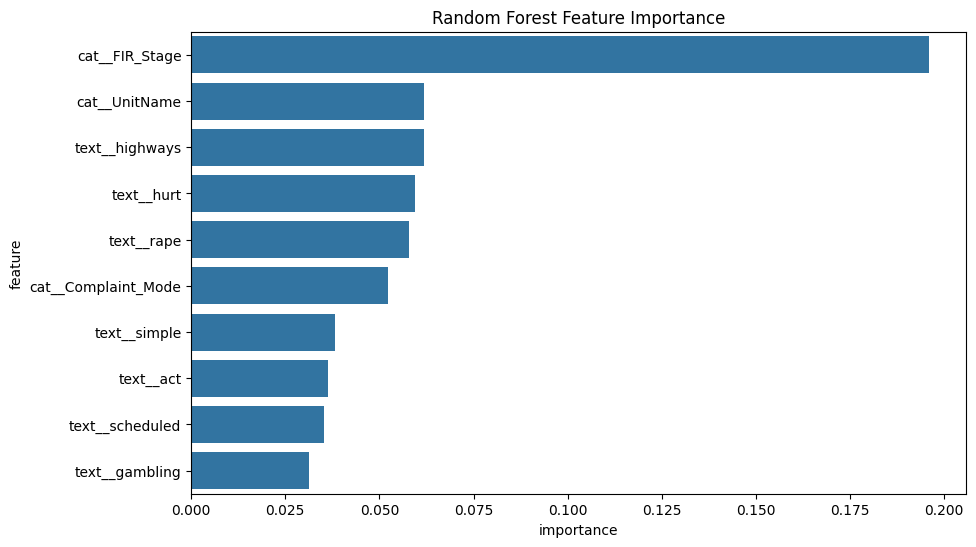

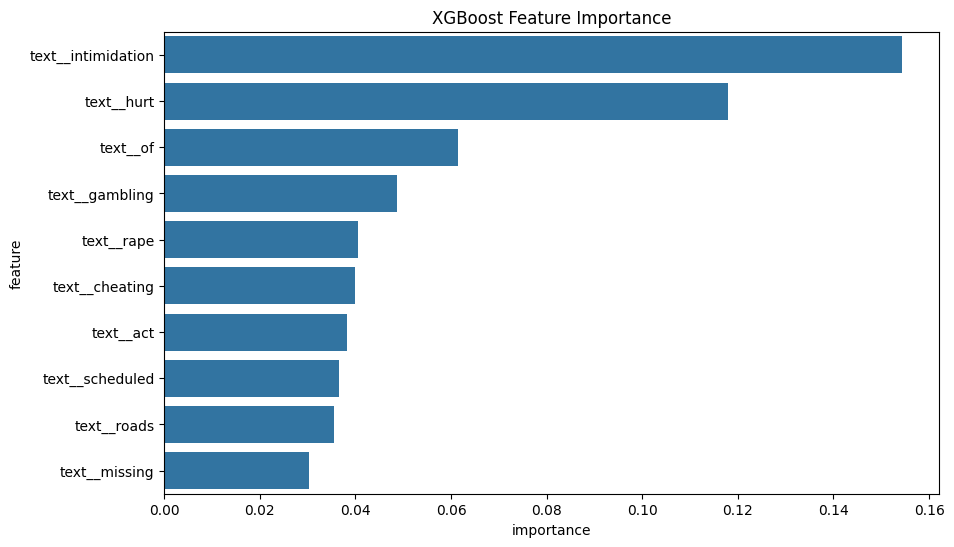

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 247507, number of negative: 495014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.295883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 990
[LightGBM] [Info] Number of data points in the train set: 742521, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


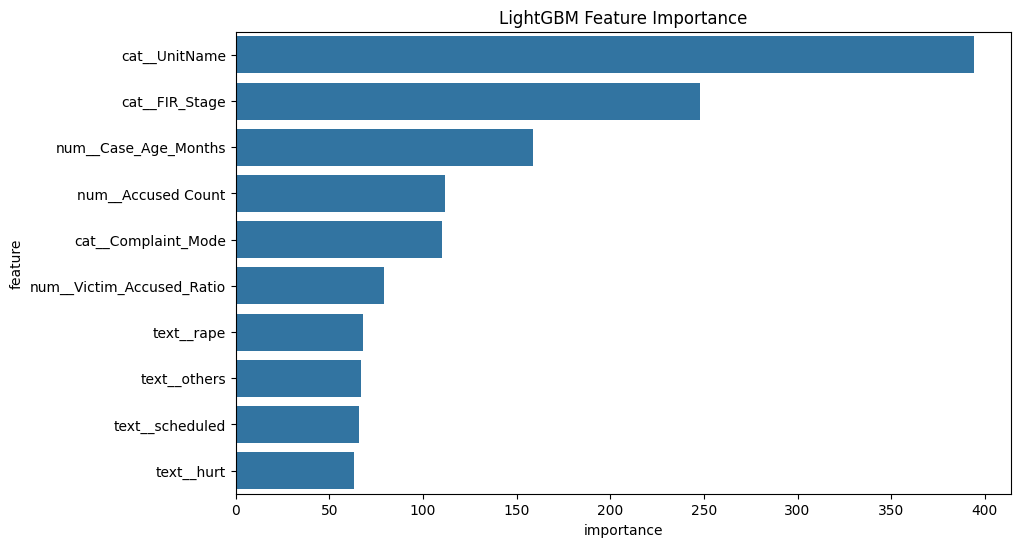

In [23]:
# Train and evaluate models
results = {}
for name, model in models.items():
    try:
        start_time = time.time()
        pipeline = imbl_pipeline(
            preprocessor,
            RandomOverSampler(sampling_strategy=0.5),
            model
        )
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time

        start_pred = time.time()
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)[:,1]  # Get probabilities for positive class

        # Store results with probabilities
        results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'train_time': train_time,
            'pred_time': time.time() - start_pred,
            'cm': confusion_matrix(y_test, y_pred),
            'y_proba': y_proba  # Store probabilities
        }

        # Feature importance for tree-based models
        if name in ['Random Forest', 'XGBoost', 'LightGBM']:
            try:
                feature_importances = pd.DataFrame({
                    'feature': preprocessor.get_feature_names_out(),
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False).head(10)

                plt.figure(figsize=(10, 6))
                sns.barplot(x='importance', y='feature', data=feature_importances)
                plt.title(f'{name} Feature Importance')
                plt.show()
            except Exception as e:
                print(f"Feature importance error for {name}: {str(e)}")

        del pipeline
        gc.collect()

    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue


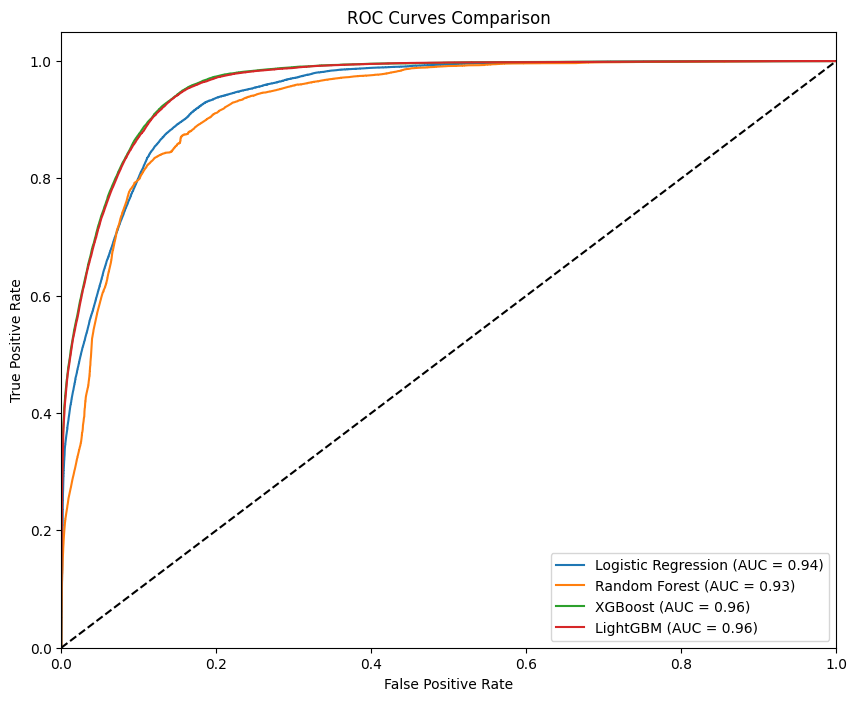


Model Performance Summary:
Model                Accuracy F1       AUC      Train Time   Pred Time   
Logistic Regression  0.85     0.59     0.94     647.34       2.44        
Random Forest        0.82     0.54     0.93     71.47        5.79        
XGBoost              0.82     0.56     0.96     13.14        4.37        
LightGBM             0.87     0.63     0.96     15.76        7.28        


In [24]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])  # Use stored probabilities
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.show()

# Print metrics
print("\nModel Performance Summary:")
print("{:<20} {:<8} {:<8} {:<8} {:<12} {:<12}".format(
    'Model', 'Accuracy', 'F1', 'AUC', 'Train Time', 'Pred Time'))
for name, res in results.items():
    print("{:<20} {:<8.2f} {:<8.2f} {:<8.2f} {:<12.2f} {:<12.2f}".format(
        name,
        res['accuracy'],
        res['f1'],
        res['roc_auc'],
        res['train_time'],
        res['pred_time']
    ))

In [30]:
# Generate realistic sample predictions with proper feature engineering
sample_data = {
    'CrimeHead_Name': ['Robbery with Violence'],  # Actual crime type from dataset
    'UnitName': ['North Division'],               # Real police division name
    'FIR_Stage': ['Under Investigation'],         # Valid investigation stage
    'Complaint_Mode': ['Oral Complaint'],         # Actual complaint type
    'FIR_YEAR': [2022],                           # Plausible year within dataset range
    'FIR_MONTH': [9],                             # Valid month value
    'VICTIM COUNT': [3],                          # Typical victim count
    'Accused Count': [2]                          # Realistic accused count
}

# Convert to DataFrame and engineer features
sample_df = pd.DataFrame(sample_data)

# Calculate derived features (MUST match training data preprocessing)
sample_df['Victim_Accused_Ratio'] = (sample_df['VICTIM COUNT'] + 1) / (sample_df['Accused Count'] + 1)
sample_df['Case_Age_Months'] = (2024 - sample_df['FIR_YEAR']) * 12 + (12 - sample_df['FIR_MONTH'])

# Reorder columns to match training data structure
sample_df = sample_df[['CrimeHead_Name', 'UnitName', 'FIR_Stage', 'Complaint_Mode',
                       'FIR_YEAR', 'FIR_MONTH', 'VICTIM COUNT', 'Accused Count',
                       'Victim_Accused_Ratio', 'Case_Age_Months']]

# Make predictions using all trained models
print("\nRealistic Sample Predictions:")
for model_name, res in results.items():
    try:
        pipeline = res['pipeline']

        # Get prediction and confidence
        pred_class = pipeline.predict(sample_df)[0]
        pred_prob = pipeline.predict_proba(sample_df)[0][1]

        print(f"\n{model_name}:")
        print(f"Prediction: {'Heinous' if pred_class == 1 else 'Non-Heinous'}")
        print(f"Confidence Score: {pred_prob:.2%}")
        print("Key Predictive Features:")
        print(f"- Victim/Accused Ratio: {sample_df['Victim_Accused_Ratio'].iloc[0]:.2f}")
        print(f"- Case Age: {sample_df['Case_Age_Months'].iloc[0]} months")

    except Exception as e:
        print(f"\n{model_name} error: {str(e)}")

# Show input context without derived features
print("\nInput Features (Raw Values):")
print(sample_df[['CrimeHead_Name', 'UnitName', 'FIR_Stage', 'Complaint_Mode',
                 'FIR_YEAR', 'FIR_MONTH', 'VICTIM COUNT', 'Accused Count']].T)


Realistic Sample Predictions:

Logistic Regression:
Prediction: Non-Heinous
Confidence Score: 26.96%
Key Predictive Features:
- Victim/Accused Ratio: 1.33
- Case Age: 27 months

Random Forest:
Prediction: Non-Heinous
Confidence Score: 43.10%
Key Predictive Features:
- Victim/Accused Ratio: 1.33
- Case Age: 27 months

XGBoost:
Prediction: Heinous
Confidence Score: 59.08%
Key Predictive Features:
- Victim/Accused Ratio: 1.33
- Case Age: 27 months

LightGBM:
Prediction: Non-Heinous
Confidence Score: 18.46%
Key Predictive Features:
- Victim/Accused Ratio: 1.33
- Case Age: 27 months

Input Features (Raw Values):
                                    0
CrimeHead_Name  Robbery with Violence
UnitName               North Division
FIR_Stage         Under Investigation
Complaint_Mode         Oral Complaint
FIR_YEAR                         2022
FIR_MONTH                           9
VICTIM COUNT                        3
Accused Count                       2


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


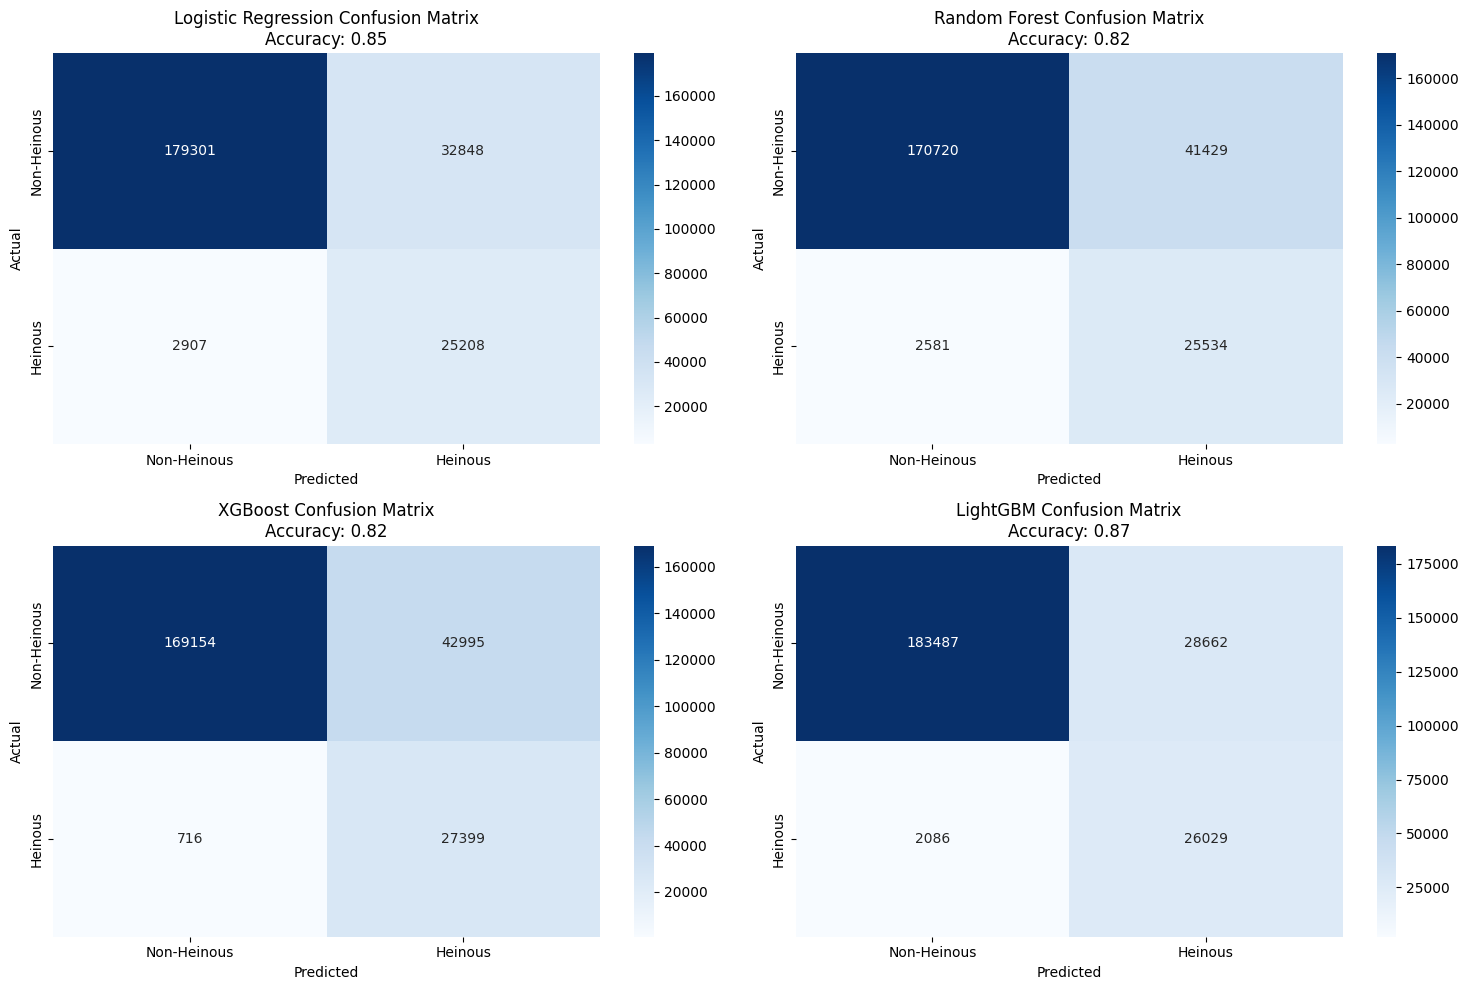


Detailed Classification Metrics:

Logistic Regression:
True Negatives:      179301
False Positives:     32848
False Negatives:     2907
True Positives:      25208
Recall:              0.90
Precision:           0.43

Random Forest:
True Negatives:      170720
False Positives:     41429
False Negatives:     2581
True Positives:      25534
Recall:              0.91
Precision:           0.38

XGBoost:
True Negatives:      169154
False Positives:     42995
False Negatives:     716
True Positives:      27399
Recall:              0.97
Precision:           0.39

LightGBM:
True Negatives:      183487
False Positives:     28662
False Negatives:     2086
True Positives:      26029
Recall:              0.93
Precision:           0.48


In [26]:
# Plot confusion matrices
plt.figure(figsize=(15, 10))
for idx, (name, res) in enumerate(results.items(), 1):
    cm = res['cm']

    plt.subplot(2, 2, idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Heinous', 'Heinous'],
                yticklabels=['Non-Heinous', 'Heinous'])
    plt.title(f'{name} Confusion Matrix\nAccuracy: {res["accuracy"]:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print classification metrics from confusion matrices
print("\nDetailed Classification Metrics:")
for name, res in results.items():
    tn, fp, fn, tp = res['cm'].ravel()
    print(f"\n{name}:")
    print(f"{'True Negatives:':<20} {tn}")
    print(f"{'False Positives:':<20} {fp}")
    print(f"{'False Negatives:':<20} {fn}")
    print(f"{'True Positives:':<20} {tp}")
    print(f"{'Recall:':<20} {tp/(tp+fn):.2f}")
    print(f"{'Precision:':<20} {tp/(tp+fp):.2f}")

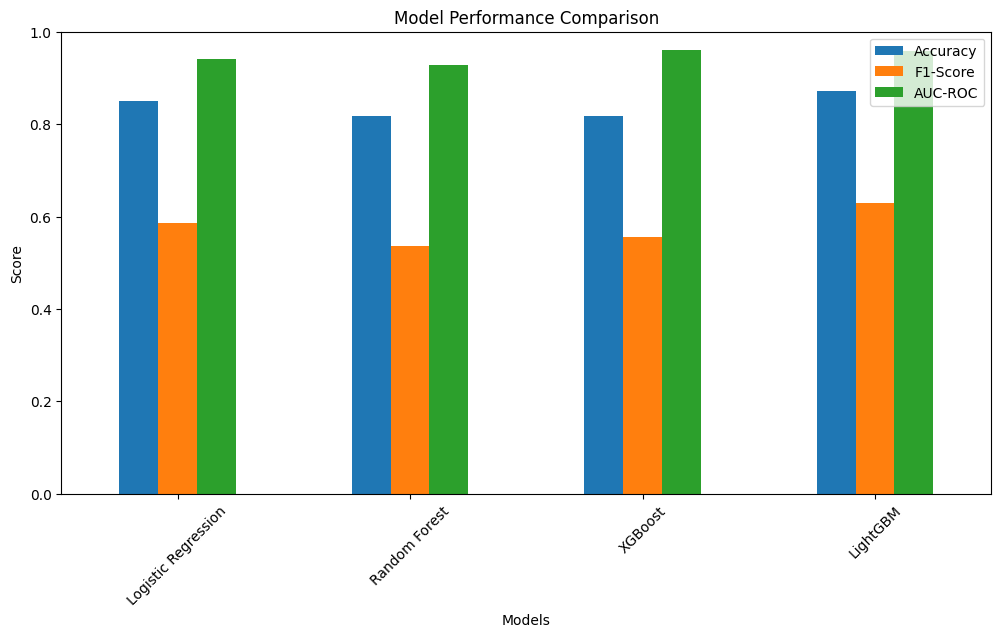

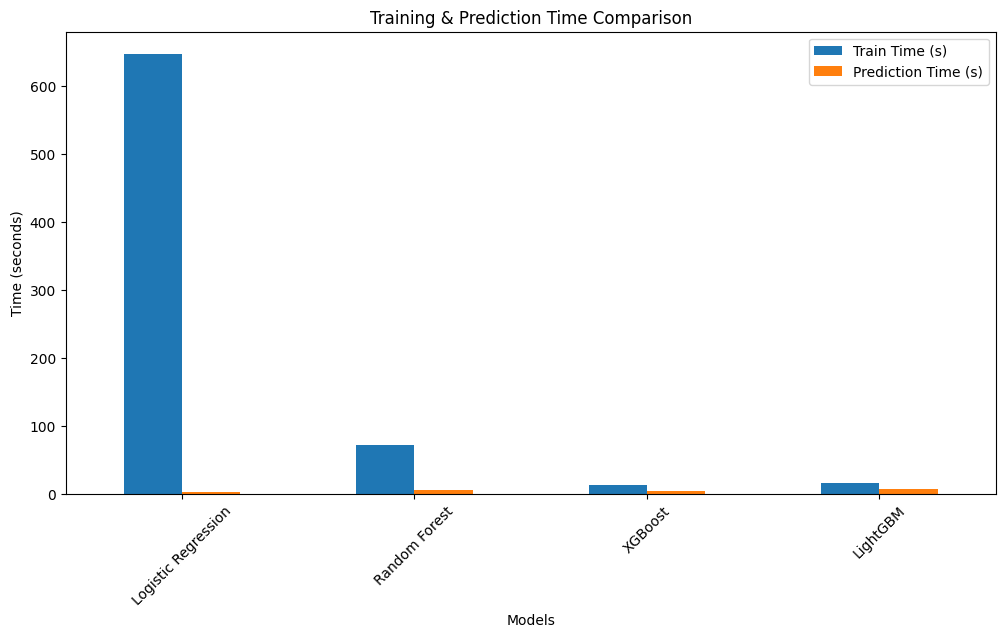

In [27]:
# Convert results dictionary into a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'F1-Score': [res['f1'] for res in results.values()],
    'AUC-ROC': [res['roc_auc'] for res in results.values()],
    'Train Time (s)': [res['train_time'] for res in results.values()],
    'Prediction Time (s)': [res['pred_time'] for res in results.values()]
}).set_index('Model')

# Plot bar chart
metrics_df[['Accuracy', 'F1-Score', 'AUC-ROC']].plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Models')
plt.ylim(0, 1)
plt.legend(loc='upper right')
plt.show()

# Plot bar chart for training and prediction times
metrics_df[['Train Time (s)', 'Prediction Time (s)']].plot(kind='bar', figsize=(12, 6), rot=45)
plt.title('Training & Prediction Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Models')
plt.legend(loc='upper right')
plt.show()